<br>
<p style="text-align: left;"><img src='https://s3.amazonaws.com/weclouddata/images/logos/sunlife_logo.png' width='35%'></p>
<p style="text-align:left;"><font size='15'><b> Machine Learning - K-Means Clustering </b></font> <br>
<h2 align='left' > Sunlife Data Science Training </h2>

<h4 align='left'>  Prepared by: <img src='https://s3.amazonaws.com/weclouddata/images/logos/wcd_logo.png' width='15%'></h4>

---

### <a name='#toc'></a> Table of Contents

1. [K-Means Explained](#section1)
  - [Explaining the EM Process](#section1.2)
  - [Implmenting Kmeans in Python](#section1.3)
  - [EM Discussions](#section1.4)

2. [Cluster Selection: Choosing Optimal K](#section2)
  - [Elbow Method](#section2.1)
  - [Silhouette Analysis](#section2.2)

3. [Mini-batch K-Meaans](#section3)

Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.

Many clustering algorithms are available in Scikit-Learn and elsewhere, but perhaps the simplest to understand is an algorithm known as k-means clustering, which is implemented in sklearn.cluster.KMeans.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; 
import numpy as np
sns.set()  # for plot styling

# <a name="section1"></a> <font color='#347B98'> 1. K-Means Explained </font> 

The k-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset. It accomplishes this using a simple conception of what the optimal clustering looks like:
* The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
* Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the k-means model. We will soon dive into exactly how the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the k-means result.

> _Check out this link for an animated visual explanation of KMeans_ ([link](http://stanford.edu/class/ee103/visualizations/kmeans/kmeans.html))


## $\Delta$ 1.1 - Generate Datasets for Clustering

### Generate sample dataset
> Change the `cluster_std` to add/reduce noise

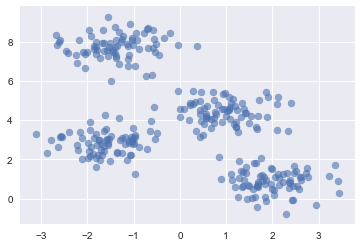

In [3]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, 
                       centers=4,
                       cluster_std=0.60, 
                       random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50, alpha=0.6);

### Fit K-Means Cluster

By eye, it is relatively easy to pick out the four clusters. The k-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [4]:
X[:10]

array([[ 0.83685684,  2.13635938],
       [-1.4136581 ,  7.40962324],
       [ 1.15521298,  5.09961887],
       [-1.01861632,  7.81491465],
       [ 1.27135141,  1.89254207],
       [ 3.43761754,  0.26165417],
       [-1.80822253,  1.59701749],
       [ 1.41372442,  4.38117707],
       [-0.20493217,  8.43209665],
       [-0.71109961,  8.66043846]])

In [5]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

> `k-means++` is an algorithm for choosing the initial values (or "seeds") for the k-means clustering algorithm. The intuition behind this approach is that spreading out the k initial cluster centers is a good thing: the first cluster center is chosen uniformly at random from the data points that are being clustered, after which each subsequent cluster center is chosen from the remaining data points with probability proportional to its squared distance from the point's closest existing cluster center.   
> To learn more about the k-means++ initialization, refer to wikipedia link: https://en.wikipedia.org/wiki/K-means%2B%2B

In [9]:
#help(KMeans)

#### $\delta$ Print cluster centers

In [6]:
kmeans.cluster_centers_

array([[ 0.94973532,  4.41906906],
       [-1.58438467,  2.83081263],
       [-1.37324398,  7.75368871],
       [ 1.98258281,  0.86771314]])

#### $\delta$ Make predictions

In [7]:
y_kmeans = kmeans.predict(X)

In [8]:
y_kmeans.shape

(300,)

Let's visualize the results by plotting the data colored by these labels. We will also plot the cluster centers as determined by the k-means estimator:

#### $\delta$ Visualize the output

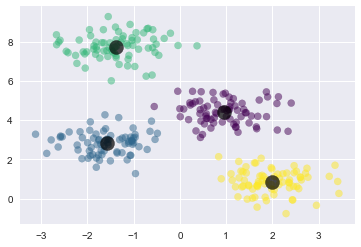

In [9]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis', alpha=0.5)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.7);

## <a name="section1.2"></a> <font color='#559E54'>$\Delta$ 1.2 - Explaining the EM Process </font>

### $\Sigma$ Explaining the Expectation Maximization process

The good news is that the k-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye. But you might wonder how this algorithm finds these clusters so quickly! After all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly. Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to k-means involves an intuitive iterative approach known as expectation–maximization.

**NOTE**:

> The script and graphs below demostrate a simple EM fit process.   
> It is used for illustration purpose. In practice, you don't need to do the following steps. 

Text(0.98,0.98,'Final Clustering')

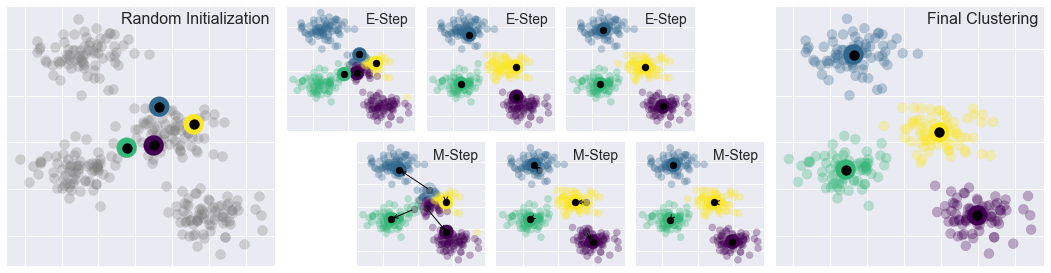

In [15]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import pairwise_distances_argmin

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

rng = np.random.RandomState(42)
centers = [0, 4] + rng.randn(4, 2)

def draw_points(ax, c, factor=1):
    ax.scatter(X[:, 0], X[:, 1], c=c, cmap='viridis',
               s=50 * factor, alpha=0.3)
    
def draw_centers(ax, centers, factor=1, alpha=1.0):
    ax.scatter(centers[:, 0], centers[:, 1],
               c=np.arange(4), cmap='viridis', s=200 * factor,
               alpha=alpha)
    ax.scatter(centers[:, 0], centers[:, 1],
               c='black', s=50 * factor, alpha=alpha)

def make_ax(fig, gs):
    ax = fig.add_subplot(gs)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    return ax

fig = plt.figure(figsize=(15, 4))
gs = plt.GridSpec(4, 15, left=0.02, right=0.98, bottom=0.05, top=0.95, wspace=0.2, hspace=0.2)
ax0 = make_ax(fig, gs[:4, :4])
ax0.text(0.98, 0.98, "Random Initialization", transform=ax0.transAxes,
         ha='right', va='top', size=16)
draw_points(ax0, 'gray', factor=2)
draw_centers(ax0, centers, factor=2)

for i in range(3):
    ax1 = make_ax(fig, gs[:2, 4 + 2 * i:6 + 2 * i])
    ax2 = make_ax(fig, gs[2:, 5 + 2 * i:7 + 2 * i])
    
    # E-step
    y_pred = pairwise_distances_argmin(X, centers)
    draw_points(ax1, y_pred)
    draw_centers(ax1, centers)
    
    # M-step
    new_centers = np.array([X[y_pred == i].mean(0) for i in range(4)])
    draw_points(ax2, y_pred)
    draw_centers(ax2, centers, alpha=0.3)
    draw_centers(ax2, new_centers)
    for i in range(4):
        ax2.annotate('', new_centers[i], centers[i],
                     arrowprops=dict(arrowstyle='->', linewidth=1))
        
    
    # Finish iteration
    centers = new_centers
    ax1.text(0.95, 0.95, "E-Step", transform=ax1.transAxes, ha='right', va='top', size=14)
    ax2.text(0.95, 0.95, "M-Step", transform=ax2.transAxes, ha='right', va='top', size=14)


# Final E-step    
y_pred = pairwise_distances_argmin(X, centers)
axf = make_ax(fig, gs[:4, -4:])
draw_points(axf, y_pred, factor=2)
draw_centers(axf, centers, factor=2)
axf.text(0.98, 0.98, "Final Clustering", transform=axf.transAxes,
         ha='right', va='top', size=16)

## <a name="section1.3"></a> <font color='#8a2be2'> 1.3 - Implementing K-Means in Python </font>

> Note this is a very simple kmeans implementation. For convergence, it checks that all points are not moving. In practice, when we have large datasets, a threshold will be set for the amount of "movement" to speed up the training. In sklearn, set parameter `n_tol` for tolerance. 

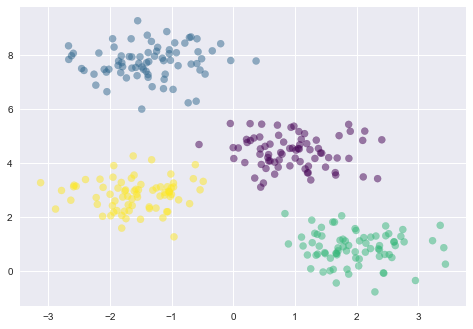

In [36]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, 
            cmap='viridis',
            alpha=0.5);

## <a name="section1.4"></a><font color='#7b68ee'>$\Delta$  1.4 - [Discussions] Caveats of Expectation Maximization


There are a few issues to be aware of when using the expectation–maximization algorithm.

> #### Caveat of EM #1: The globally optimal result may not be achieved

First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the global best solution. For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

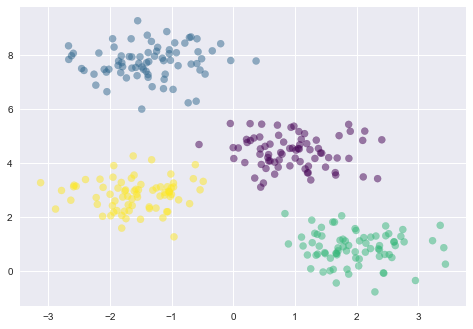

In [18]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, 
            cmap='viridis',
            alpha=0.5);

> #### Caveat of EM #2: The number of clusters must be selected beforehand

Another common challenge with k-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data. For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

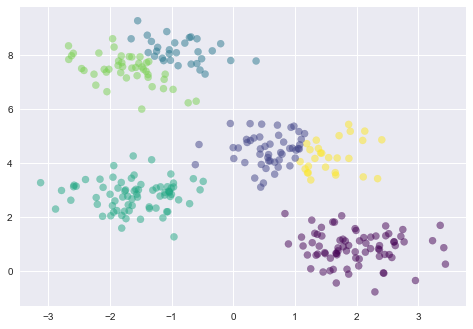

In [37]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, 
            cmap='viridis',
            alpha=0.5);

Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive, but that we won't discuss further in this lab, is called [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html). We will cover `silhouette analysis` in a separate lab.

Alternatively, you might use a more complicated clustering algorithm which has a better quantitative measure of the fitness per number of clusters (e.g., Gaussian mixture models) or which can choose a suitable number of clusters (e.g., DBSCAN, mean-shift, or affinity propagation, all available in the sklearn.cluster submodule)

> #### Caveat of EM #3: k-means is limited to linear cluster boundaries

The fundamental model assumptions of k-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between k-means clusters will always be linear, which means that it will fail for more complicated boundaries. Consider the following data, along with the cluster labels found by the typical k-means approach:

In [38]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

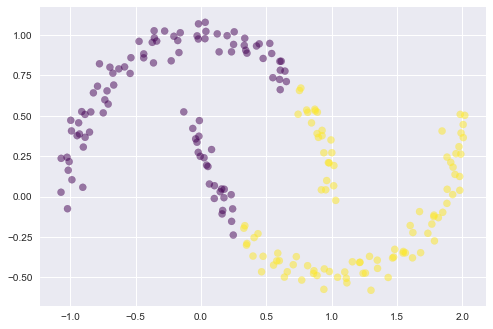

In [39]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis', alpha=0.5);

> This situation is reminiscent of the discussion in In-Depth: Support Vector Machines, where we used a kernel transformation to project the data into a higher dimension where a linear separation is possible. We might imagine using the same trick to allow k-means to discover non-linear boundaries.


> #### Caveat of EM #4: Kmeans can be slow

Because each iteration of k-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows. You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step. This is the idea behind batch-based k-means algorithms, one form of which is implemented in sklearn.cluster.MiniBatchKMeans. The interface for this is the same as for standard KMeans; 

> We will discuss mini-batch kmeans in the next lab!

---

# <a name='section2'></a><font color='#347B98'> 2. Cluster Selection: Choosing the best `K`

## <a name='section2.1'></a> <font color='#FC7307'>$\Delta$ 2.1 - The Elbow Method </font>
The K-Means algorithm is somewhat naive. **`It clusters the data into k clusters, even if k is not the right number of clusters to use`**. Therefore, when using k-means clustering, users need some way to determine whether they are using the right number of clusters.

One method to validate the number of clusters is the **`elbow method`**. The idea of the elbow method is to run k-means clustering on the dataset for a range of values of k (say, k from 1 to 10 in the examples above), and for each value of k calculate the sum of squared errors (SSE).

Then, plot a line chart of the SSE for each value of k. If the line chart looks like an arm, then the "elbow" on the arm is the value of k that is the best. 

> The idea is that we want a small SSE, but that the SSE tends to decrease toward 0 as we increase k (**the SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster**). So our goal is to choose a small value of k that still has a low SSE, and the elbow usually represents where we start to have diminishing returns by increasing k.

In [6]:
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=0.3,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1) 

plt.figure(figsize=(7,7))
plt.title("Random Data for Clustering")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")

plt.scatter(X[:, 0], X[:, 1], 
            marker='.', 
            s=60, 
            lw=0, 
            alpha=0.5, 
            c='green', 
            edgecolor='k')

plt.show()

The distortion is the **within-cluster sum of square errors (WCSSE)** – that’s 3 things that need to take place: 
- determine the error,   
- square it,   
- then finally take the sum.

<img src='https://s3.amazonaws.com/weclouddata/images/python/cluster_wcsse.png' width='50%'>

The “error” in this case is the difference between each data point coordinates and the centroid coordinates.

The SSE is simply:

<img src='https://s3.amazonaws.com/weclouddata/images/python/clustering_sse_equation.png' width='50%'>

All we’re doing is:
* taking the difference between each data point and a centroid
* squaring that difference
* and summing it all up!

<img src='https://s3.amazonaws.com/weclouddata/images/python/cluster_sse_xls.png' width='50%'>


> $ (4.03 – 0.99)^2 + (-2.95 + 1.00)^2 + (-3.88 – 0.99)^2 + (2.73 + 1.00)^2…$

Continue by matching each Data X and Y value to their corresponding centroid X and Y values, sum it up and you’ll get the within cluster SSE or distortion. In Python this value can be retrieved using the `Kmeans.intertia_` variable

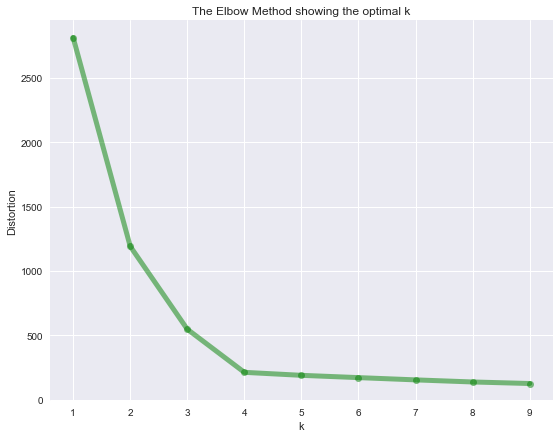

In [8]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    #distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    distortions.append(kmeanModel.inertia_)

# Plot the elbow
plt.figure(figsize=(9,7))
plt.plot(K, distortions, 'bo-', alpha=0.5, c='green', lw=5)
plt.xlabel('k')
plt.ylabel('Distortion')
plt.grid(True)
plt.title('The Elbow Method showing the optimal k')
plt.show()

> K=4 seems to be a very good elbow cutoff in this case!

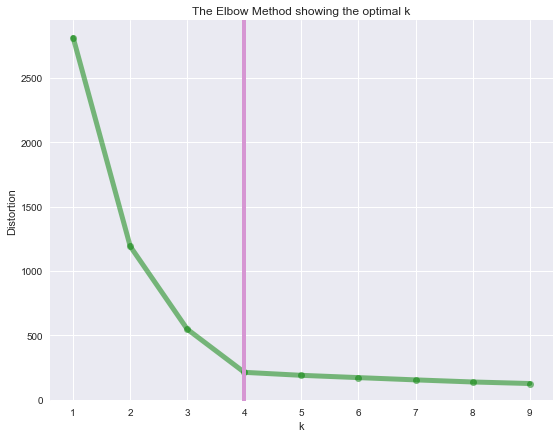

In [9]:
# Plot the elbow
plt.figure(figsize=(9,7))
plt.plot(K, distortions, 'bo-', alpha=0.5, c='green', lw=5)
plt.xlabel('k')
plt.ylabel('Distortion')
plt.grid(True)
plt.title('The Elbow Method showing the optimal k')
plt.axvline(4, lw=4, color='#D696D3')
plt.show()

## <a name='section2.2'></a> <font color='#559E54'>$\Delta$ 2.2 - Silhouette Analysis </font>

Silhouette analysis can be used to study the `separation distance` between the resulting clusters and thus a good metric used for choosing an optimal value for n_clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. 

### $\Delta$ Silhouette Coefficient

**Silhouette coefficient value has a range of [-1, 1]**

> Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters.   
> A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters.   
> Negative coefficient values indicate that those samples might have been assigned to the wrong cluster.  


### $\delta$ 2.2.1 - Generate Data 

In [23]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=2,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

### $\delta$ 2.2.2 - Fit a K-Means Model

In [24]:
n_clusters = 4

clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(X)

### $\delta$ 2.2.3 - Visualize Clustering Result

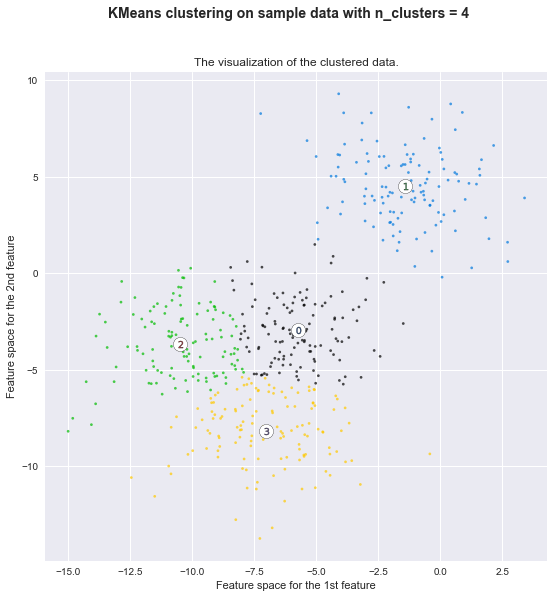

In [25]:
fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(9, 9)

colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
ax1.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax1.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax1.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax1.set_title("The visualization of the clustered data.")
ax1.set_xlabel("Feature space for the 1st feature")
ax1.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("KMeans clustering on sample data "
              "with n_clusters = %d" % n_clusters),
             fontsize=14, fontweight='bold')
plt.show()

### <font color='#8a2be2'>  $\delta$ 2.2.4 - Compute Silhouette Scores

#### $\sigma$ Silhouette for all samples

In [26]:
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)


For n_clusters = 4 The average silhouette_score is : 0.4425408153760203


#### $\sigma$ Silhouette score by cluster

In [27]:
import pandas as pd

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

# Calculate score by cluster
silhouette_df = pd.DataFrame(list(zip(cluster_labels, sample_silhouette_values)), columns=['cluster_id','score'])
silhouette_df.groupby('cluster_id').mean()

,score
cluster_id,
0,0.406474
1,0.612972
2,0.389226
3,0.364788


### <font color='#8a2be2'>  $\delta$ 2.2.5 - Visualizing Silhouette Coefficient

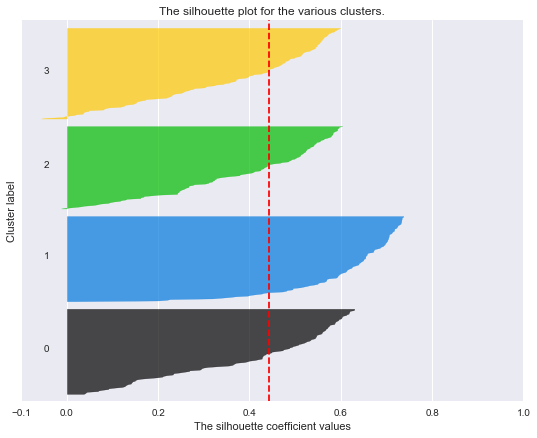

In [28]:
# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.

fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(9, 7)
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])


y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, 
                      ith_cluster_silhouette_values,
                      facecolor=color, 
                      edgecolor=color, 
                      alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples


ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()


### <font color='#8a2be2'>  $\delta$ 2.2.6 - Silhouette Analysis for Various Size of K

For n_clusters = 2 The average silhouette_score is : 0.6017706066112086


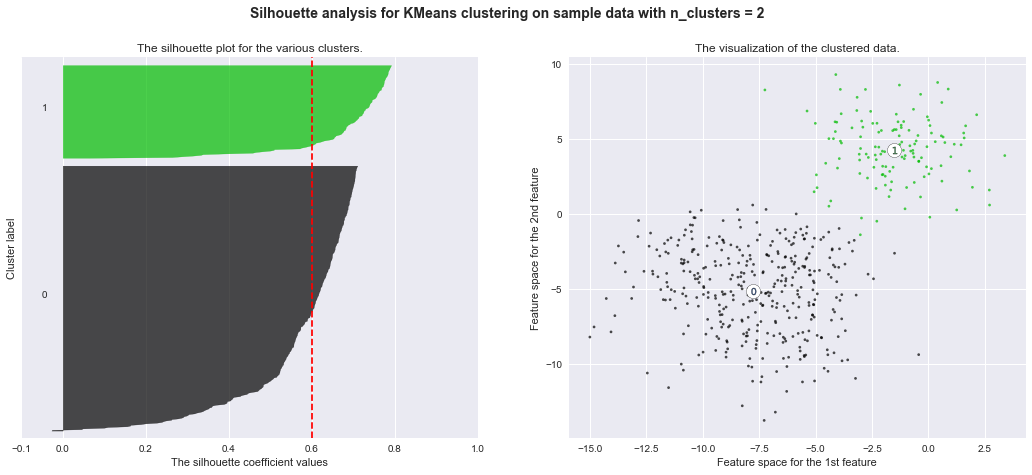

For n_clusters = 3 The average silhouette_score is : 0.43154039349506557


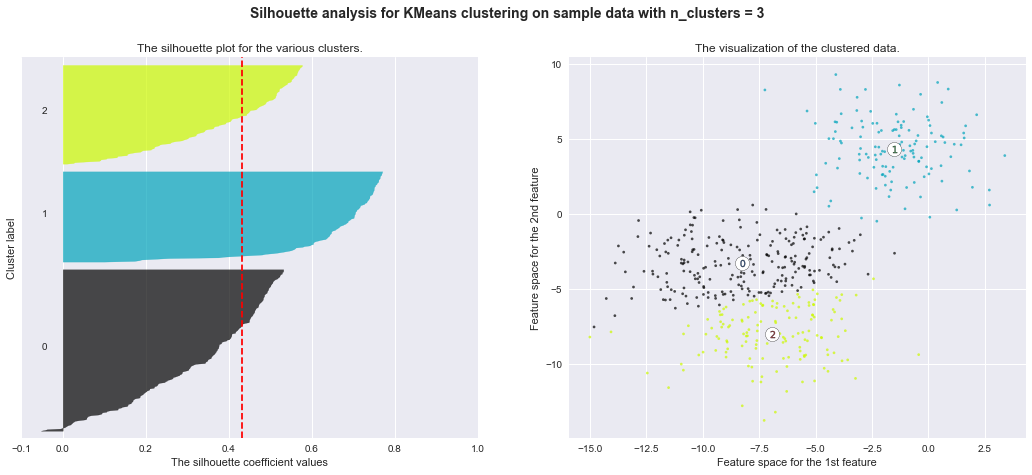

For n_clusters = 4 The average silhouette_score is : 0.4425408153760203


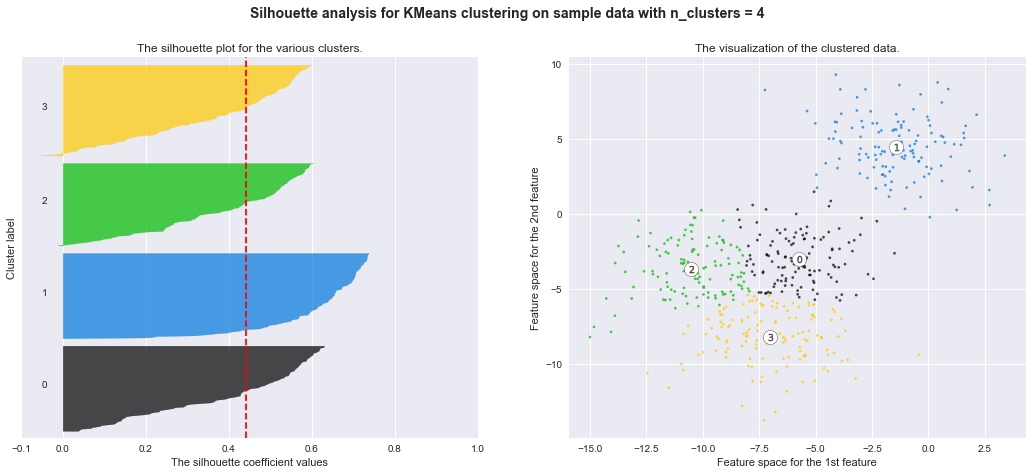

For n_clusters = 5 The average silhouette_score is : 0.3952482053967923


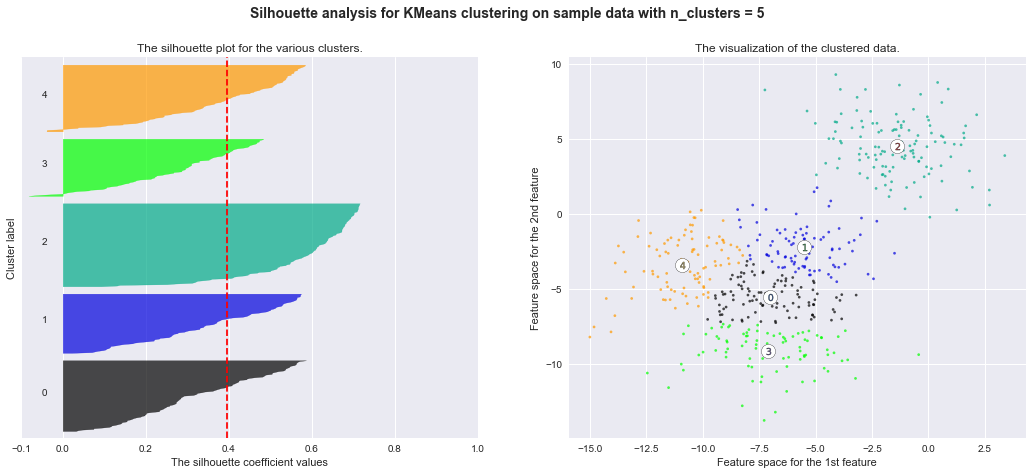

For n_clusters = 6 The average silhouette_score is : 0.3466773733092859


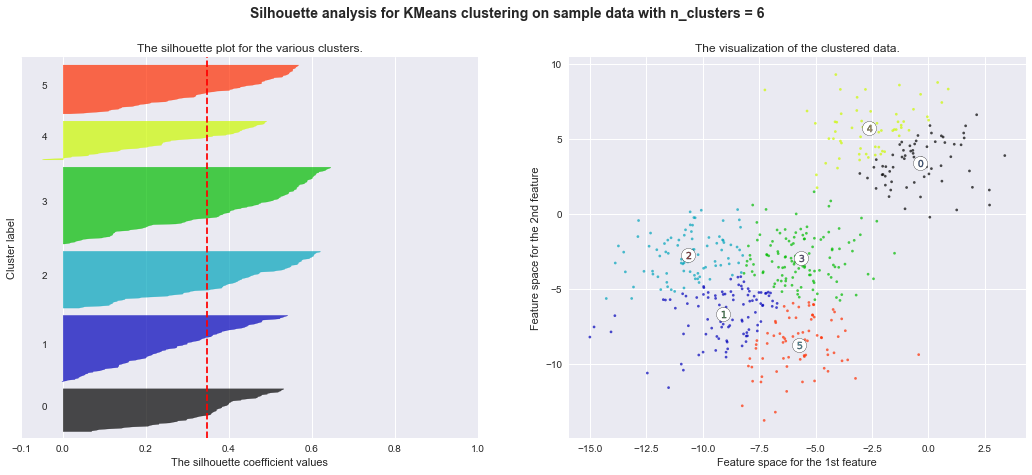

In [29]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

**Discussion**
> The silhouette plot shows that the n_clusters value of 3, 5 and 6 are a bad pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. Silhouette analysis is more ambivalent in deciding between 2 and 4. Also from the thickness of the silhouette plot the cluster size can be visualized. The silhouette plot for cluster 0 when n_clusters is equal to 2, is bigger in size owing to the grouping of the 3 sub clusters into one big cluster. However when the n_clusters is equal to 4, all the plots are more or less of similar thickness and hence are of similar sizes as can be also verified from the labelled scatter plot on the right.




---

# <a name='section3'></a><font color='#347B98'> 3. Mini-batch K-Means
    
The `MiniBatchKMeans` is a variant of the `KMeans` algorithm which uses mini-batches to reduce the computation time, while still attempting to optimise the same objective function. 

Mini-batches are subsets of the input data, randomly sampled in each training iteration. These mini-batches drastically reduce the amount of computation required to converge to a local solution. In contrast to other algorithms that reduce the convergence time of k-means, mini-batch k-means produces results that are generally only slightly worse than the standard algorithm.

The algorithm iterates between two major steps, similar to vanilla k-means. 
> In the first step, b samples are drawn randomly from the dataset, to form a mini-batch. These are then assigned to the nearest centroid.  
> In the second step, the centroids are updated.  

In contrast to k-means, this is done on a per-sample basis. For each sample in the mini-batch, the assigned centroid is updated by taking the streaming average of the sample and all previous samples assigned to that centroid. This has the effect of decreasing the rate of change for a centroid over time. These steps are performed until convergence or a predetermined number of iterations is reached.

> `MiniBatchKMeans` converges faster than `KMeans`, but the quality of the results is reduced. In practice this difference in quality can be quite small, as shown in the example and cited reference.

In [26]:
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets.samples_generator import make_blobs

In [27]:
np.random.seed(0)

batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=30000, centers=centers, cluster_std=0.7)

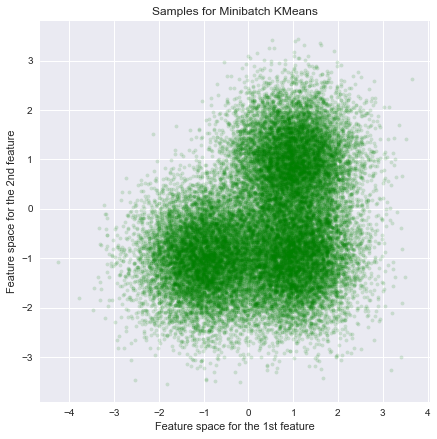

In [28]:
plt.figure(figsize=(7,7))
plt.title("Samples for Minibatch KMeans")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")

plt.scatter(X[:, 0], X[:, 1], 
            marker='.', 
            s=60, 
            lw=0, 
            alpha=0.15, 
            c='green', 
            edgecolor='k')

plt.show()

## <a name='section2.2'></a> <font color='#559E54'>$\Delta$ 3.1 - Runtime: K-Means vs MiniBatch K-Means </font>

### <font color='#8a2be2'>  $\delta$ 3.1.1 - K-Means

In [30]:
# K-Means

k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0
print("Training time for Kmeans: {}".format(t_batch))

Training time for Kmeans: 0.19791793823242188


### <font color='#8a2be2'>  $\delta$ 3.1.2 - Mini-batch K-Means

In [31]:
# MiniBatchKMeans

mbk = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0
print("Training time for Mini-batch Kmeans: {}".format(t_mini_batch))

Training time for Mini-batch Kmeans: 0.09599471092224121


### <font color='#8a2be2'>  $\delta$ 3.1.3 - Visualize the different

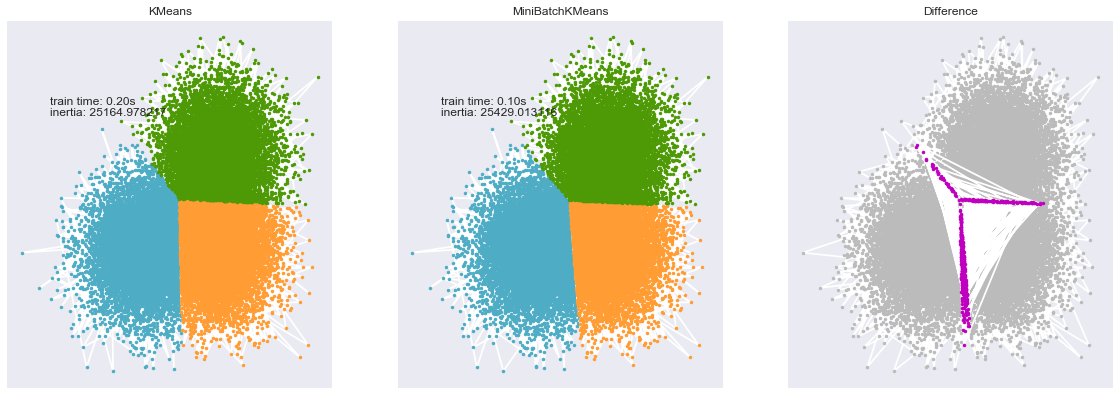

In [32]:
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

# We want to have the same colors for the same cluster from the
# MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per
# closest one.
k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis=0)
mbk_means_cluster_centers = np.sort(mbk.cluster_centers_, axis=0)
k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)
order = pairwise_distances_argmin(k_means_cluster_centers,
                                  mbk_means_cluster_centers)

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8,  'train time: %.2fs\ninertia: %f' % (
    t_batch, k_means.inertia_))

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == order[k]
    cluster_center = mbk_means_cluster_centers[order[k]]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, 'train time: %.2fs\ninertia: %f' %
         (t_mini_batch, mbk.inertia_))

# Initialise the different array to all False
different = (mbk_means_labels == 4)
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += ((k_means_labels == k) != (mbk_means_labels == order[k]))

identic = np.logical_not(different)
ax.plot(X[identic, 0], X[identic, 1], 'w',
        markerfacecolor='#bbbbbb', marker='.')
ax.plot(X[different, 0], X[different, 1], 'w',
        markerfacecolor='m', marker='.')
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())

plt.show()

---